In [42]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import math
import scipy.stats as stats
# from scipy.optimize import curve_fit

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn.preprocessing as prep
import sklearn.metrics as metrics
from sklearn import model_selection

from rfpimp import dropcol_importances
from rfpimp import importances

import pickle

## Helper Functions

#### Helper functions for plotting

In [43]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, 
                     trend_line=False, trend_order=1, trend_color=None, 
                     title='', length_label='', tick_labels='', tick_axis_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        labels = []
        for i, lab in enumerate(bars):
            if bar_labels=='':
                labels.append([f"{j:.4f}" for j in cells[i]])
            else:
                labels.append(bar_labels[i])
#             labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_xticklabels(cols)
        else:
            ax.set_xticklabels(tick_labels)
        if not length_label=='':
            ax.set_ylabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_xlabel(tick_axis_label, fontsize=12, fontweight='bold')
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_yticklabels(cols)
        else:
            ax.set_yticklabels(tick_labels)
        if not length_label=='':
            ax.set_xlabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_ylabel(tick_axis_label, fontsize=12, fontweight='bold')
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title, fontsize=14, fontweight='bold')
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    ax.grid(True, axis='y')

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True, annotate=False, annot_kwargs=8):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=annotate,
                annot_kws={'size': annot_kwargs})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values
    
def plot_mae_deciles(model, X, y_true, y_bl, index, ax, log_transform=False, cumulative=False, title=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y_bl = np.exp(y_bl.values) - 1
    y_mae_model = np.abs(y_true - y_pred)
    y_mae_naive = np.abs(y_true - np.mean(y_bl))
    y = np.stack([y_mae_model, y_mae_naive], axis=1)
    y = pd.DataFrame(y, index=index, columns=['mae_model', 'mae_naive']).sort_values(by='mae_model', ascending=True)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    mae_model = []
    mae_naive = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            mae_model.append(np.mean(y.loc[y['deciles']<=i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']<=i, 'mae_naive']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population')
            ax.set_ylabel('Mean absolute error \n (cumulative mean)')
        else:
            mae_model.append(np.mean(y.loc[y['deciles']==i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']==i, 'mae_naive']))
            ax.set_xlabel('Deciles')
            ax.set_ylabel('Mean absolute error \n (mean per decile)')
    data = np.stack([mae_model, mae_naive], axis=1)
    data = pd.DataFrame(data, columns=['mae_model', 'mae_naive'])

    _x = data.index
    _y = data['mae_model'].values
    ax.plot(_x, _y, marker='o', color='b')
    
    _y = data['mae_naive']
    ax.plot(_x, _y, marker='o', color='r')
    
    ax.legend(['Model predictions', 'Naive predictions'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    if log_transform:
        ax.set_yscale('log')
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_sale_change_deciles(model, X, y_true, y_bl, index, ax, cumulative=False, title=None, colors=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y_bl = np.exp(y_bl.values) - 1
    sale_change_pred = y_pred - y_bl
    sale_change_true = y_true - y_bl
    y = np.stack([sale_change_pred, sale_change_true], axis=1)
    y = pd.DataFrame(y, index=index, columns=['sale_change_pred', 'sale_change_true']).sort_values(by='sale_change_pred', ascending=False)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    sale_change_pred = []
    sale_change_true = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            sale_change_pred.append(np.mean(y.loc[y['deciles']<=i, 'sale_change_pred']))
            sale_change_true.append(np.mean(y.loc[y['deciles']<=i, 'sale_change_true']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales change \n (mean per % of population)', fontsize=12, fontweight='bold')
        else:
            sale_change_pred.append(np.mean(y.loc[y['deciles']==i, 'sale_change_pred']))
            sale_change_true.append(np.mean(y.loc[y['deciles']==i, 'sale_change_true']))
            ax.set_xlabel('Deciles', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales change \n (mean per decile)', fontsize=12, fontweight='bold')
    data = np.stack([sale_change_pred, sale_change_true], axis=1)
    data = pd.DataFrame(data, columns=['sale_change_pred', 'sale_change_true'])

    _x = data.index
    _y = data['sale_change_pred'].values
    ax.plot(_x, _y, marker='o', color=('tab:blue' if colors is None else colors[0]))
    
    _y = data['sale_change_true']
    ax.plot(_x, _y, marker='o', color=('tab:orange' if colors is None else colors[0]))
    
    ax.legend(['Predicted sales change', 'True sales change'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_sales_deciles(model, X, y_true, index, ax, cumulative=False, log_transform=False, title=None, colors=None):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y = np.stack([y_pred, y_true], axis=1)
    y = pd.DataFrame(y, index=index, columns=['sales_pred', 'sales_true']).sort_values(by='sales_pred', ascending=False)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    sales_pred = []
    sales_true = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            sales_pred.append(np.mean(y.loc[y['deciles']<=i, 'sales_pred']))
            sales_true.append(np.mean(y.loc[y['deciles']<=i, 'sales_true']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales \n (mean per % of population)', fontsize=12, fontweight='bold')
        else:
            sales_pred.append(np.mean(y.loc[y['deciles']==i, 'sales_pred']))
            sales_true.append(np.mean(y.loc[y['deciles']==i, 'sales_true']))
            ax.set_xlabel('Deciles', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales \n (mean per decile)', fontsize=12, fontweight='bold')
    data = np.stack([sales_pred, sales_true], axis=1)
    data = pd.DataFrame(data, columns=['sales_pred', 'sales_true'])

    _x = data.index
    _y = data['sales_pred'].values
    ax.plot(_x, _y, marker='o', color=('tab:blue' if colors is None else colors[0]))
    
    _y = data['sales_true']
    ax.plot(_x, _y, marker='o', color=('tab:orange' if colors is None else colors[0]))
    
    if log_transform:
        ax.set_yscale('log')
    
    ax.legend(['Predicted sales', 'True sales'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_deciles_data(data, figname='', color='dimgrey', plot_type='bar', trend_line=False, trend_order=1, trend_color='dimgrey', cumulative_pop=False, data_labels=False, x_label=None, y_label=None):
    grd = list(data.columns)
    grd_n = len(grd)
    grd_cols_n = 2
    grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

    plt_h = 4
    plt_w = 12
    
    fig_ttl = plt.figure()
    fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
    ax0 = fig_ttl.add_subplot()
    ax0.text(0.5, 0.5, figname, fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax0.axis('off')

    fig = plt.figure()
    fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
    gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

    for idx, col in enumerate(list(data.columns)):
        if data_labels:
            labs = ['{0:.2f}'.format(i) for i in data[col]]
            bar_labels=[labs]
        else:
            bar_labels=None
        
        if cumulative_pop:
            tick_labels = np.arange(10,110,10)
        else:
            tick_labels = list(data.index)
        
        if x_label is not None:
            tick_axis_label = x_label
        else:
            tick_axis_label = ''
        if y_label is not None:
            length_label = y_label
        else:
            length_label = col
        
        if plot_type=='bar':
            plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                             data=data[col].to_frame().T,
                             bar_labels=bar_labels,
                             tick_labels = tick_labels,
                             plots_labels=None,
                             plots_colors=[color],
                             width=0.3,
                             trend_line=trend_line, 
                             trend_order=trend_order, 
                             trend_color=[trend_color],
                             title=None,
                             tick_axis_label=tick_axis_label,
                             length_label=length_label,
                             orient='v',
                             spines={'top': False, 'right': False})
        elif plot_type=='scatter':
            ax=fig.add_subplot(gs[idx])
            _x = tick_labels
            _y = data[col].values
            ax.scatter(_x, _y, marker='o', color=color)
            z = np.polyfit(_x, _y, 2)
            p = np.poly1d(z)
            ax.plot(_x, p(_x), color=color)
            
def plot_cls_ratio_deciles(models, Xs, ys_true, indexes, ax, by_class=1, cumulative=False, title=None, legend=None, colors=None):
    deciles = []
    _legend = []
    for idx, model in enumerate(models):
        y_pred = model.predict(Xs[idx])
        y_prob = model.predict_proba(Xs[idx])
        y_true = ys_true[idx]

        y_byclass = np.stack([y_true, y_pred, y_prob[:,by_class]], axis=1)
        y_byclass = pd.DataFrame(y_byclass, index=indexes[idx], columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
        y_dec = np.zeros(len(y_true))
        n = len(y_dec) // 10
        N = 10 * n
        for i in range(0, N, n):
            if i==N:
                y_dec[i:] = i/n
            else:
                y_dec[i:i+n] = i/n
        y_byclass['deciles'] = y_dec
        y_byclass['deciles'] = y_byclass['deciles'].astype('int32')

        dec_labs = y_byclass['deciles'].unique()
        correct_pred_rate_byclass = []
#         correct_pred_rate_othclass = []
        for i in dec_labs:
            dec_samples = (y_byclass.loc[y_byclass['deciles']<=i] if cumulative else y_byclass.loc[y_byclass['deciles']==i])
            n_true_byclass = len(dec_samples.loc[dec_samples['true_y']==by_class])
            n_correct_pred_byclass = len(dec_samples.loc[(dec_samples['true_y']==by_class) & (dec_samples['predicted_y']==by_class)])
            correct_pred_rate_byclass.append(n_correct_pred_byclass / n_true_byclass)
            
#             n_true_othclass = len(dec_samples.loc[dec_samples['true_y']!=by_class])
#             n_correct_pred_othclass = len(dec_samples.loc[(dec_samples['true_y']!=by_class) & (dec_samples['predicted_y']!=by_class)])
#             correct_pred_rate_othclass.append(n_correct_pred_othclass / n_true_othclass)
        
        y_othclass = np.stack([y_true, y_pred, y_prob[:,np.abs(by_class-1)]], axis=1)
        y_othclass = pd.DataFrame(y_othclass, index=indexes[idx], columns=['true_y', 'predicted_y', 'proba_y']).sort_values(by='proba_y', ascending=False)
        y_dec = np.zeros(len(y_true))
        n = len(y_dec) // 10
        N = 10 * n
        for i in range(0, N, n):
            if i==N:
                y_dec[i:] = i/n
            else:
                y_dec[i:i+n] = i/n
        y_othclass['deciles'] = y_dec
        y_othclass['deciles'] = y_othclass['deciles'].astype('int32')

        dec_labs = y_othclass['deciles'].unique()
#         correct_pred_rate_byclass = []
        correct_pred_rate_othclass = []
        for i in dec_labs:
            dec_samples = (y_othclass.loc[y_othclass['deciles']<=i] if cumulative else y_othclass.loc[y_othclass['deciles']==i])
#             n_true_byclass = len(dec_samples.loc[dec_samples['true_y']==by_class])
#             n_correct_pred_byclass = len(dec_samples.loc[(dec_samples['true_y']==by_class) & (dec_samples['predicted_y']==by_class)])
#             correct_pred_rate_byclass.append(n_correct_pred_byclass / n_true_byclass)
            
            n_true_othclass = len(dec_samples.loc[dec_samples['true_y']!=by_class])
            n_correct_pred_othclass = len(dec_samples.loc[(dec_samples['true_y']!=by_class) & (dec_samples['predicted_y']!=by_class)])
            correct_pred_rate_othclass.append(n_correct_pred_othclass / n_true_othclass)

        _x = np.arange(10)
        _y_byclass = np.array(correct_pred_rate_byclass)
        _y_othclass = np.array(correct_pred_rate_othclass)
        _colors = ([list(mcolors.TABLEAU_COLORS.keys())[idx], 
                    list(mcolors.TABLEAU_COLORS.keys())[len(mcolors.TABLEAU_COLORS.keys())-1-idx]] if colors is None else colors[idx])
        ax.plot(_x, _y_byclass, marker='o', color=_colors[0])
        ax.plot(_x, _y_othclass, marker='o', color=_colors[1])
        
        _legend.append('model {0} target class'.format(idx))
        _legend.append('model {0} other class'.format(idx))
        deciles.append(y_byclass['deciles'])
    
    ax.set_xticks(np.arange(10))
    
    if cumulative:
        ax.set_xticklabels(np.arange(10,110,10))
        ax.set_xlabel('% of population', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correct predictions rate \n (per % of population)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels(np.arange(1,11))
        ax.set_xlabel('Deciles', fontsize=14, fontweight='bold')
        ax.set_ylabel('Correct predictions rate \n (per decile)', fontsize=12, fontweight='bold')
    
    if legend is None:
        legend = _legend
    ax.legend(legend)
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    ax.grid(True)

    return deciles
            
def plot_diagram_xy(data, x, y, ax, x_title=None, y_title=None, x_labels_format='{0:.2f}', title=None, pot_size=None):
    _data = data.copy()
    _data = _data.sort_values(by=x, ascending=False)
    _data['qcut'] = pd.cut(_data[x], 10, labels=False, duplicates='drop')

    cuts = _data['qcut'].unique()
    _x = np.zeros(len(cuts))
    _y = np.zeros(len(cuts))
    for idx, i in enumerate(cuts):
        _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, x])
        _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['qcut']==i, y])
    plot_bar_diagram(ax=ax,
                     data=pd.Series(_y).to_frame().T,
                     tick_labels=[x_labels_format.format(i) for i in _x],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=(x if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def get_lift_chart(model, X, y_true, by_class=1):
    y_pred = np.exp(model.predict(X)) - 1
    y_true = np.exp(y_true.values) - 1
    y = np.stack([y_true, y_pred], axis=1)
    y = pd.DataFrame(y, columns=['true_y', 'predicted_y']).sort_values(by='true_y', ascending=False)
    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    def p_cum_sum(arr_n, arr_p, pos):
        arr = []
        for i in range(pos + 1):
            arr.append(arr_p[i] * arr_n[i])
        return np.sum(arr)

    dec_labs = y['deciles'].unique()
    total_mean = np.mean(y['true_y'])
    n_samples = []
    dec_mean = []
    dec_lift_ovr_mean = []
    n_cum_samples = []
    cum_mean = []
    cum_lift_ovr_mean = []
    for i in dec_labs:
        dec_samples = y.loc[y['deciles']==i]

        n = len(dec_samples)
        p = np.mean(dec_samples['true_y'])
        lift_ovr = p / total_mean - 1

        n_samples.append(n)
        dec_mean.append(p)
        dec_lift_ovr_mean.append(lift_ovr)

        n_cum = len(y.loc[y['deciles']<=i])
        p_cum = (p if i==0 else p_cum_sum(n_samples, dec_mean, i) / n_cum)
        lift_ovr_cum = p_cum / total_mean - 1

        n_cum_samples.append(n_cum)
        cum_mean.append(p_cum)
        cum_lift_ovr_mean.append(lift_ovr_cum)
    lift = np.stack([n_samples, dec_mean, dec_lift_ovr_mean, n_cum_samples, cum_mean, cum_lift_ovr_mean], axis=1)
    return total_mean, pd.DataFrame(lift, columns=['n_samples', 'dec_mean', 'dec_lift_ovr_mean', 'n_cum_samples', 'cum_mean', 'cum_lift_ovr_mean'])

#### Helper functions for model training

In [44]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

#### Load data

In [45]:
data_2018 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions18',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions18


In [46]:
data_2019 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions19',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions19


#### Drop refresh date column

In [47]:
data_2018 = data_2018.drop(columns=['refresh_date'])

In [48]:
data_2019 = data_2019.drop(columns=['refresh_date'])

#### Add target columns

In [49]:
data_2019.columns = [i + '_target' for i in list(data_2019.columns)]

In [50]:
data_2019 = data_2019.loc[data_2018.index]

In [51]:
data = pd.concat([data_2018, data_2019], axis=1)

In [52]:
print('Data shape: ', data.shape)

Data shape:  (10005, 38)


#### Deal with NaNs

In [53]:
print('Percent of missing values: {0:.0%}'.format(data.isnull().sum().mean() / len(data)))

Percent of missing values: 36%


In [54]:
data.isnull().sum()

no_of_sales_12M_1                      5242
no_of_Redemption_12M_1                 4644
no_of_sales_12M_10K                    7293
no_of_Redemption_12M_10K               7029
no_of_funds_sold_12M_1                 5242
no_of_funds_redeemed_12M_1             4644
no_of_fund_sales_12M_10K               7293
no_of_funds_Redemption_12M_10K         7029
no_of_assetclass_sold_12M_1            5242
no_of_assetclass_redeemed_12M_1        4644
no_of_assetclass_sales_12M_10K         7293
no_of_assetclass_Redemption_12M_10K    7029
No_of_fund_curr                        3822
No_of_asset_curr                       4426
AUM                                     585
sales_curr                             7574
sales_12M                              5237
redemption_curr                        7429
redemption_12M                         4621
new_Fund_added_12M                     7310
aum_AC_EQUITY                           585
aum_AC_FIXED_INCOME_MUNI                585
aum_AC_FIXED_INCOME_TAXABLE     

All data is numeric and and naturaly is equal or more than zero. So will fill nans with zeros.

In [55]:
data = data.fillna(value=0)

In [56]:
data.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
no_of_sales_12M_1,10005.0,20.082159,9.844041e+01,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,2.000,5.000,13.000000,39.000000,4.395000e+03
no_of_Redemption_12M_1,10005.0,20.976412,1.915516e+02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,1.000000,2.000,5.000,12.000000,36.000000,1.215200e+04
no_of_sales_12M_10K,10005.0,2.420090,1.453480e+01,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.000,1.000000,5.000000,9.860000e+02
no_of_Redemption_12M_10K,10005.0,1.856372,1.223371e+01,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.000,1.000000,4.000000,8.830000e+02
no_of_funds_sold_12M_1,10005.0,1.359920,2.379880e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000,1.000,2.000000,4.000000,3.200000e+01
no_of_funds_redeemed_12M_1,10005.0,1.544328,2.467777e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,1.000000,1.000,2.000,3.000000,4.000000,3.300000e+01
no_of_fund_sales_12M_10K,10005.0,0.570315,1.329914e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.000,1.000000,2.000000,1.900000e+01
no_of_funds_Redemption_12M_10K,10005.0,0.607896,1.358727e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000,0.000,1.000000,2.000000,2.100000e+01
no_of_assetclass_sold_12M_1,10005.0,0.786207,1.004772e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000,1.000,2.000000,2.000000,5.000000e+00
no_of_assetclass_redeemed_12M_1,10005.0,0.906747,1.046786e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,1.000000,1.000,1.000,2.000000,2.000000,5.000000e+00


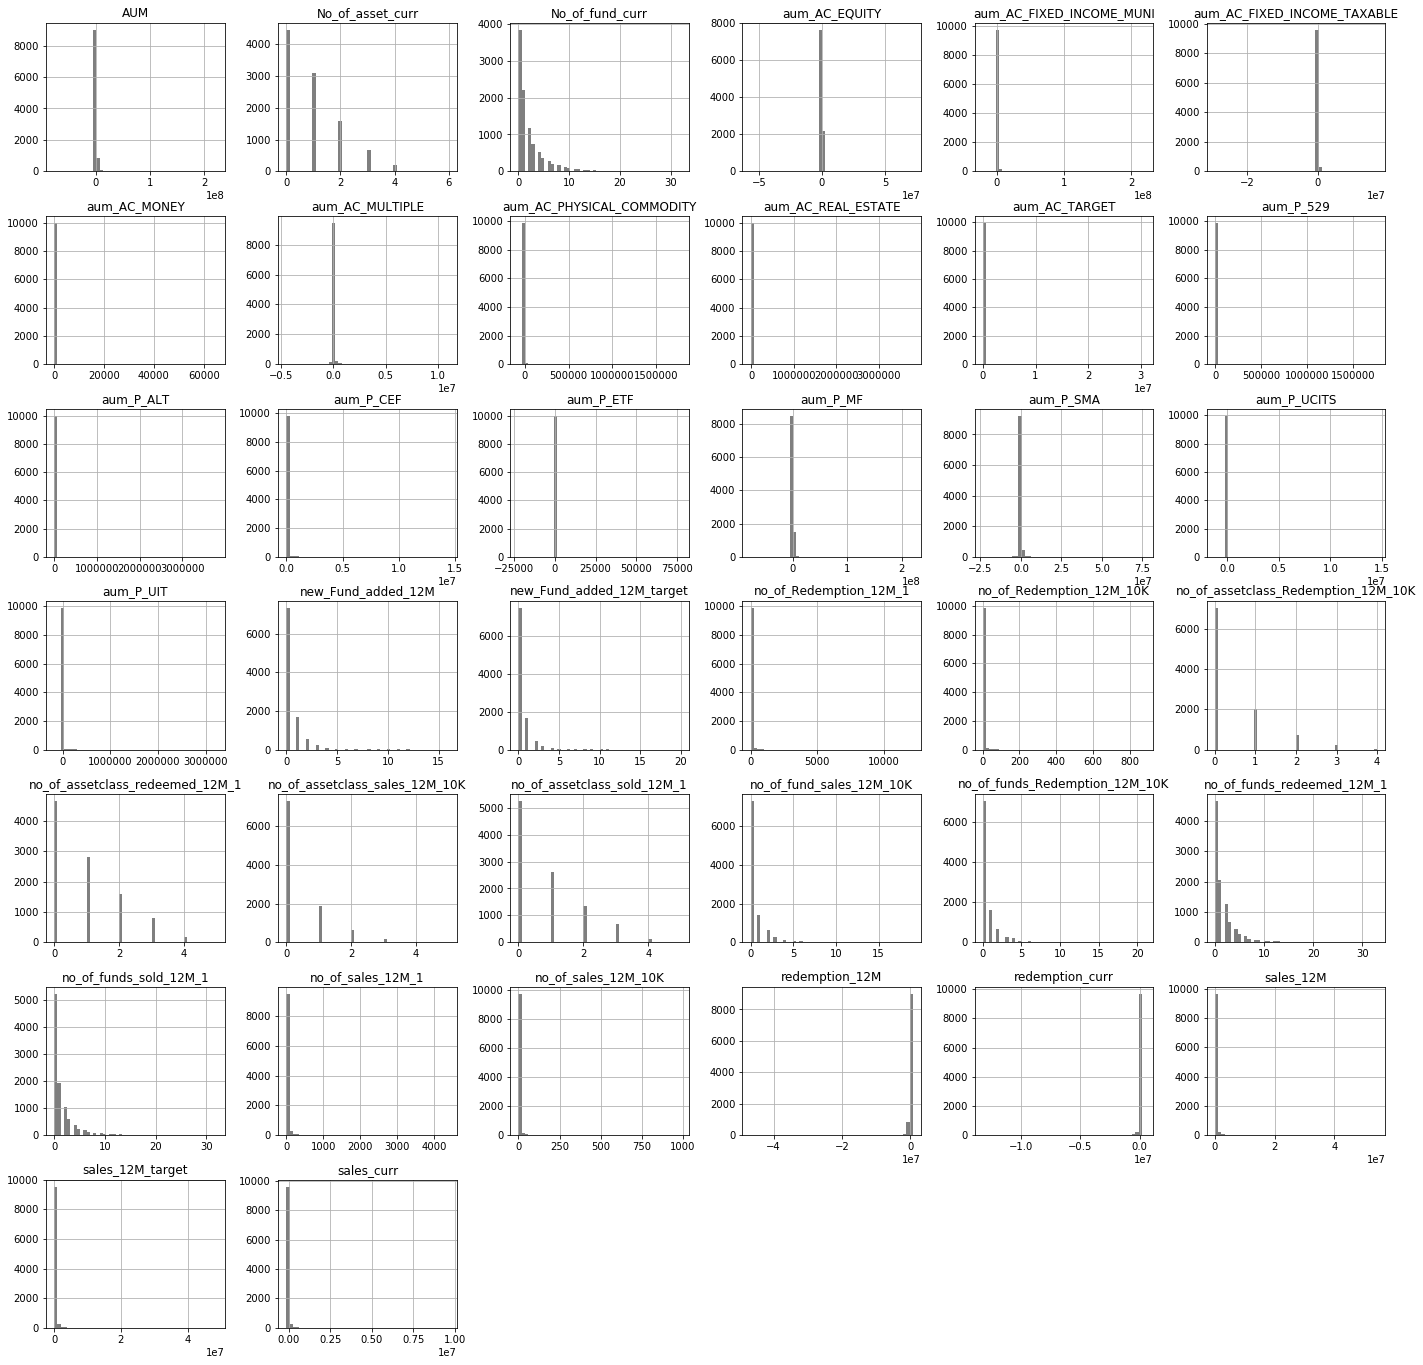

In [57]:
data.hist(color='k', alpha=0.5, bins=50, figsize=(24,24))
plt.savefig('temp.jpg')

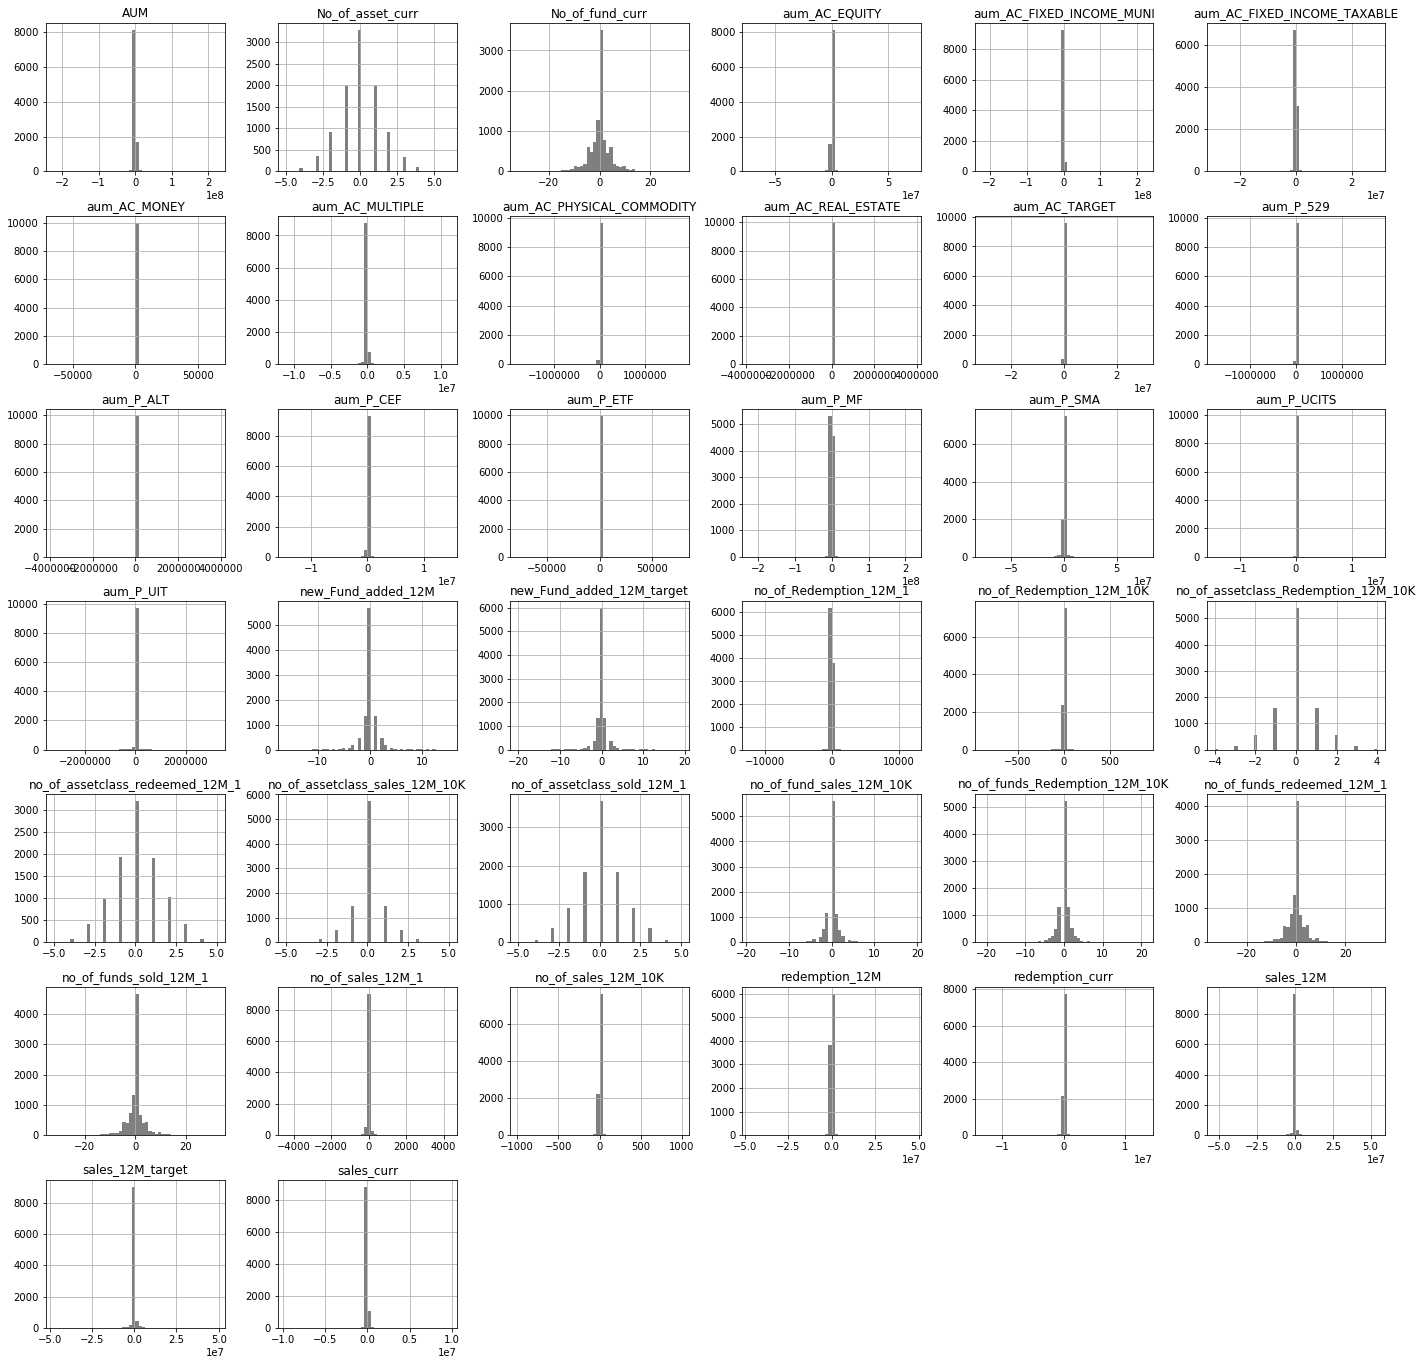

In [58]:
data.diff().hist(color='k', alpha=0.5, bins=50, figsize=(24,24))
plt.savefig('temp.jpg')

#### Drop samples that have negative sales and positive redemptions

In [59]:
# Inspect positive variables
f_pos = ['sales_12M_target',
         'AUM', 
         'sales_curr',         
         'sales_12M',
         'aum_AC_EQUITY',
         'aum_AC_FIXED_INCOME_MUNI',
         'aum_AC_FIXED_INCOME_TAXABLE',
         'aum_AC_MULTIPLE',
         'aum_AC_PHYSICAL_COMMODITY',
         'aum_AC_REAL_ESTATE',
         'aum_AC_TARGET',
         'aum_P_529',
         'aum_P_ETF',
         'aum_P_MF',
         'aum_P_SMA',
         'aum_P_UCITS',
         'aum_P_UIT']

for i in f_pos:
    print(i, len(data.loc[data[i] < 0]))

sales_12M_target 2
AUM 4377
sales_curr 4
sales_12M 7
aum_AC_EQUITY 3871
aum_AC_FIXED_INCOME_MUNI 3276
aum_AC_FIXED_INCOME_TAXABLE 1694
aum_AC_MULTIPLE 1149
aum_AC_PHYSICAL_COMMODITY 90
aum_AC_REAL_ESTATE 3
aum_AC_TARGET 19
aum_P_529 14
aum_P_ETF 5
aum_P_MF 4564
aum_P_SMA 1151
aum_P_UCITS 15
aum_P_UIT 42


In [60]:
# Inspect negative variables
f_neg = ['redemption_curr',
'redemption_12M']

for i in f_neg:
    print(i, len(data.loc[data[i] > 0]))

redemption_curr 3
redemption_12M 4


In [61]:
data = data.loc[(data['sales_12M']>=0) & 
         (data['sales_12M_target']>=0) & 
         (data['sales_curr']>=0) & 
         (data['redemption_curr']<=0) & 
         (data['redemption_12M']<=0)]

#### Reverse redemptions sign

In [62]:
for i in f_neg:
    data[i] = data[i].apply(np.abs)

#### Add delta_sales = sales_12M_2019 - sales_12M_2018

In [63]:
data['delta_sales_12M_18_19'] = (data['sales_12M_target'] - data['sales_12M'])

#### Add net sales data (net_sales = sales - redumptions)

In [64]:
net_cols = {'net_no_of_sales_12M_1': ['no_of_sales_12M_1', 'no_of_Redemption_12M_1'], 
            'net_no_of_sales_12M_10K': ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K'], 
            'net_no_of_funds_sold_12M_1': ['no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1'], 
            'net_no_of_fund_sales_12M_10K': ['no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K'], 
            'net_no_of_assetclass_sold_12M_1': ['no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1'], 
            'net_no_of_assetclass_sales_12M_10K': ['no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K']}

In [65]:
for net_col in net_cols.keys():
    data[net_col] = data[net_cols[net_col][0]] - data[net_cols[net_col][1]]

In [66]:
data['net_sales_curr'] = data['sales_curr'] - data['redemption_curr']
data['net_sales_12M'] = data['sales_12M'] - data['redemption_12M']

#### Split aum columns into positive and negative columns

In [67]:
aum_cols = []
for i in list(data.columns):
    if 'aum' in i:
        aum_cols.append(i)

In [68]:
for aum_col in aum_cols:
    data['pos_' + aum_col] = data[aum_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + aum_col] = data[aum_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Split net columns into positive and negative columns

In [69]:
for net_col in list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M']:
    data['pos_' + net_col] = data[net_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + net_col] = data[net_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Make a copy of data for post-processing

In [70]:
data_raw = data.copy()

#### Apply log-transform to continuous features

In [71]:
# Drop columns that have negative values
data = data.drop(columns=aum_cols)
data = data.drop(columns=['AUM'])
data = data.drop(columns=list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M'])

In [72]:
for i in ['sales_curr',
          'sales_12M',
          'redemption_curr',
          'redemption_12M',
          'pos_aum_AC_EQUITY',
          'neg_aum_AC_EQUITY',
          'pos_aum_AC_FIXED_INCOME_MUNI',
          'neg_aum_AC_FIXED_INCOME_MUNI',
          'pos_aum_AC_FIXED_INCOME_TAXABLE',
          'neg_aum_AC_FIXED_INCOME_TAXABLE',
          'pos_aum_AC_MONEY',
          'neg_aum_AC_MONEY',
          'pos_aum_AC_MULTIPLE',
          'neg_aum_AC_MULTIPLE',
          'pos_aum_AC_PHYSICAL_COMMODITY',
          'neg_aum_AC_PHYSICAL_COMMODITY',
          'pos_aum_AC_REAL_ESTATE',
          'neg_aum_AC_REAL_ESTATE',
          'pos_aum_AC_TARGET',
          'neg_aum_AC_TARGET',
          'pos_aum_P_529',
          'neg_aum_P_529',
          'pos_aum_P_ALT',
          'neg_aum_P_ALT',
          'pos_aum_P_CEF',
          'neg_aum_P_CEF',
          'pos_aum_P_ETF',
          'neg_aum_P_ETF',
          'pos_aum_P_MF',
          'neg_aum_P_MF',
          'pos_aum_P_SMA',
          'neg_aum_P_SMA',
          'pos_aum_P_UCITS',
          'neg_aum_P_UCITS',
          'pos_aum_P_UIT',
          'neg_aum_P_UIT',
          'pos_net_sales_curr',
          'pos_net_sales_12M',
          'neg_net_sales_curr',
          'neg_net_sales_12M']:
    data[i] = data[i].apply(lambda x: np.log(x+2))

#### Encode target feature

In [73]:
data['new_Fund_added_12M_target'] = data['new_Fund_added_12M_target'].apply(lambda x: 1 if x > 0 else 0)

#### Data summary

In [74]:
data_cols = ['sales_12M_target', 'new_Fund_added_12M_target']

In [75]:
for col in list(data.columns):
    if not col in data_cols:
        data_cols.append(col)

In [76]:
data = data[data_cols]

In [77]:
data_desc = data.describe().T
data_desc

,count,mean,std,min,25%,50%,75%,max
sales_12M_target,9988.0,211519.205077,1.139872e+06,0.000000,0.000000,87.575000,45143.376250,4.867638e+07
new_Fund_added_12M_target,9988.0,0.251502,4.338980e-01,0.000000,0.000000,0.000000,1.000000,1.000000e+00
no_of_sales_12M_1,9988.0,20.049760,9.849246e+01,0.000000,0.000000,0.000000,8.000000,4.395000e+03
no_of_Redemption_12M_1,9988.0,20.966860,1.917042e+02,0.000000,0.000000,1.000000,8.000000,1.215200e+04
no_of_sales_12M_10K,9988.0,2.415098,1.452724e+01,0.000000,0.000000,0.000000,1.000000,9.860000e+02
...,...,...,...,...,...,...,...,...
neg_net_no_of_assetclass_sales_12M_10K,9988.0,0.178815,4.544581e-01,0.000000,0.000000,0.000000,0.000000,4.000000e+00
pos_net_sales_curr,9988.0,1.933027,2.962739e+00,0.693147,0.693147,0.693147,0.693147,1.608138e+01
neg_net_sales_curr,9988.0,2.151050,3.268324e+00,0.693147,0.693147,0.693147,0.693147,1.620685e+01
pos_net_sales_12M,9988.0,3.514470,4.634025e+00,0.693147,0.693147,0.693147,7.771091,1.697736e+01


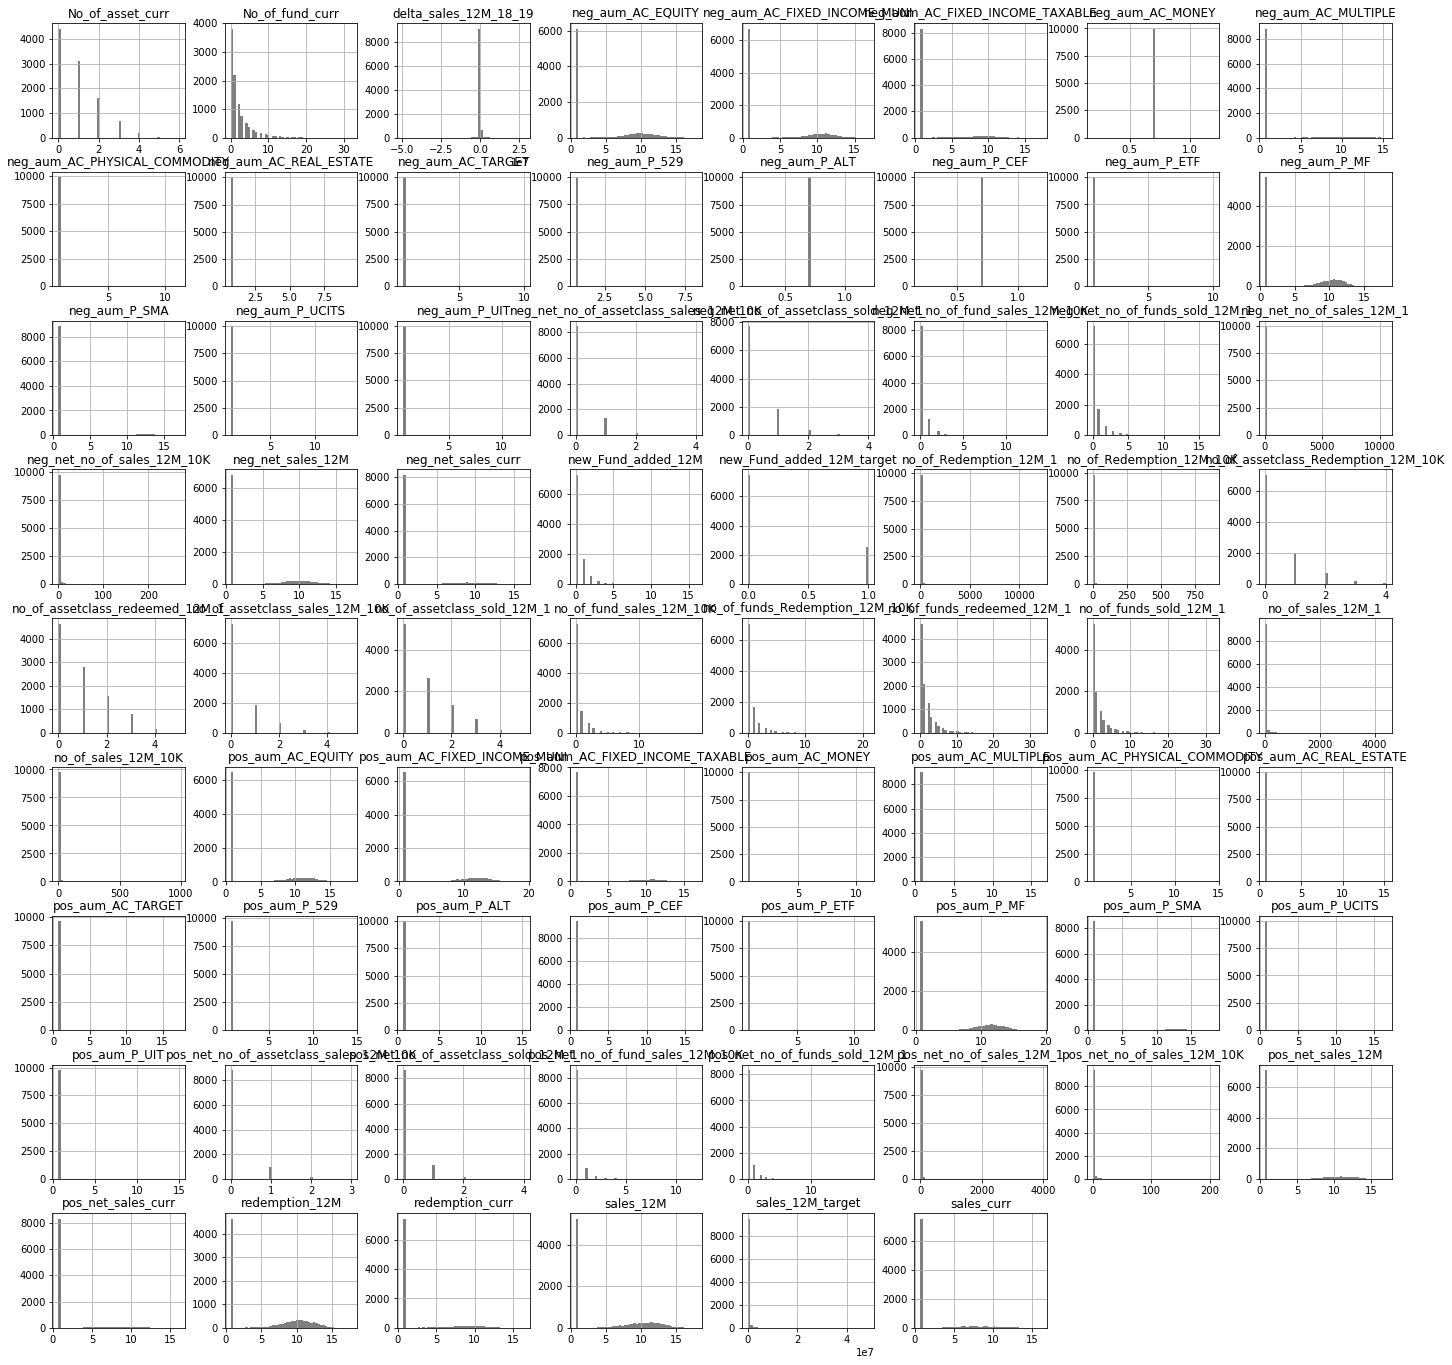

In [78]:
data.hist(color='k', alpha=0.5, bins=50, figsize=(24,24))
plt.savefig('temp.jpg')

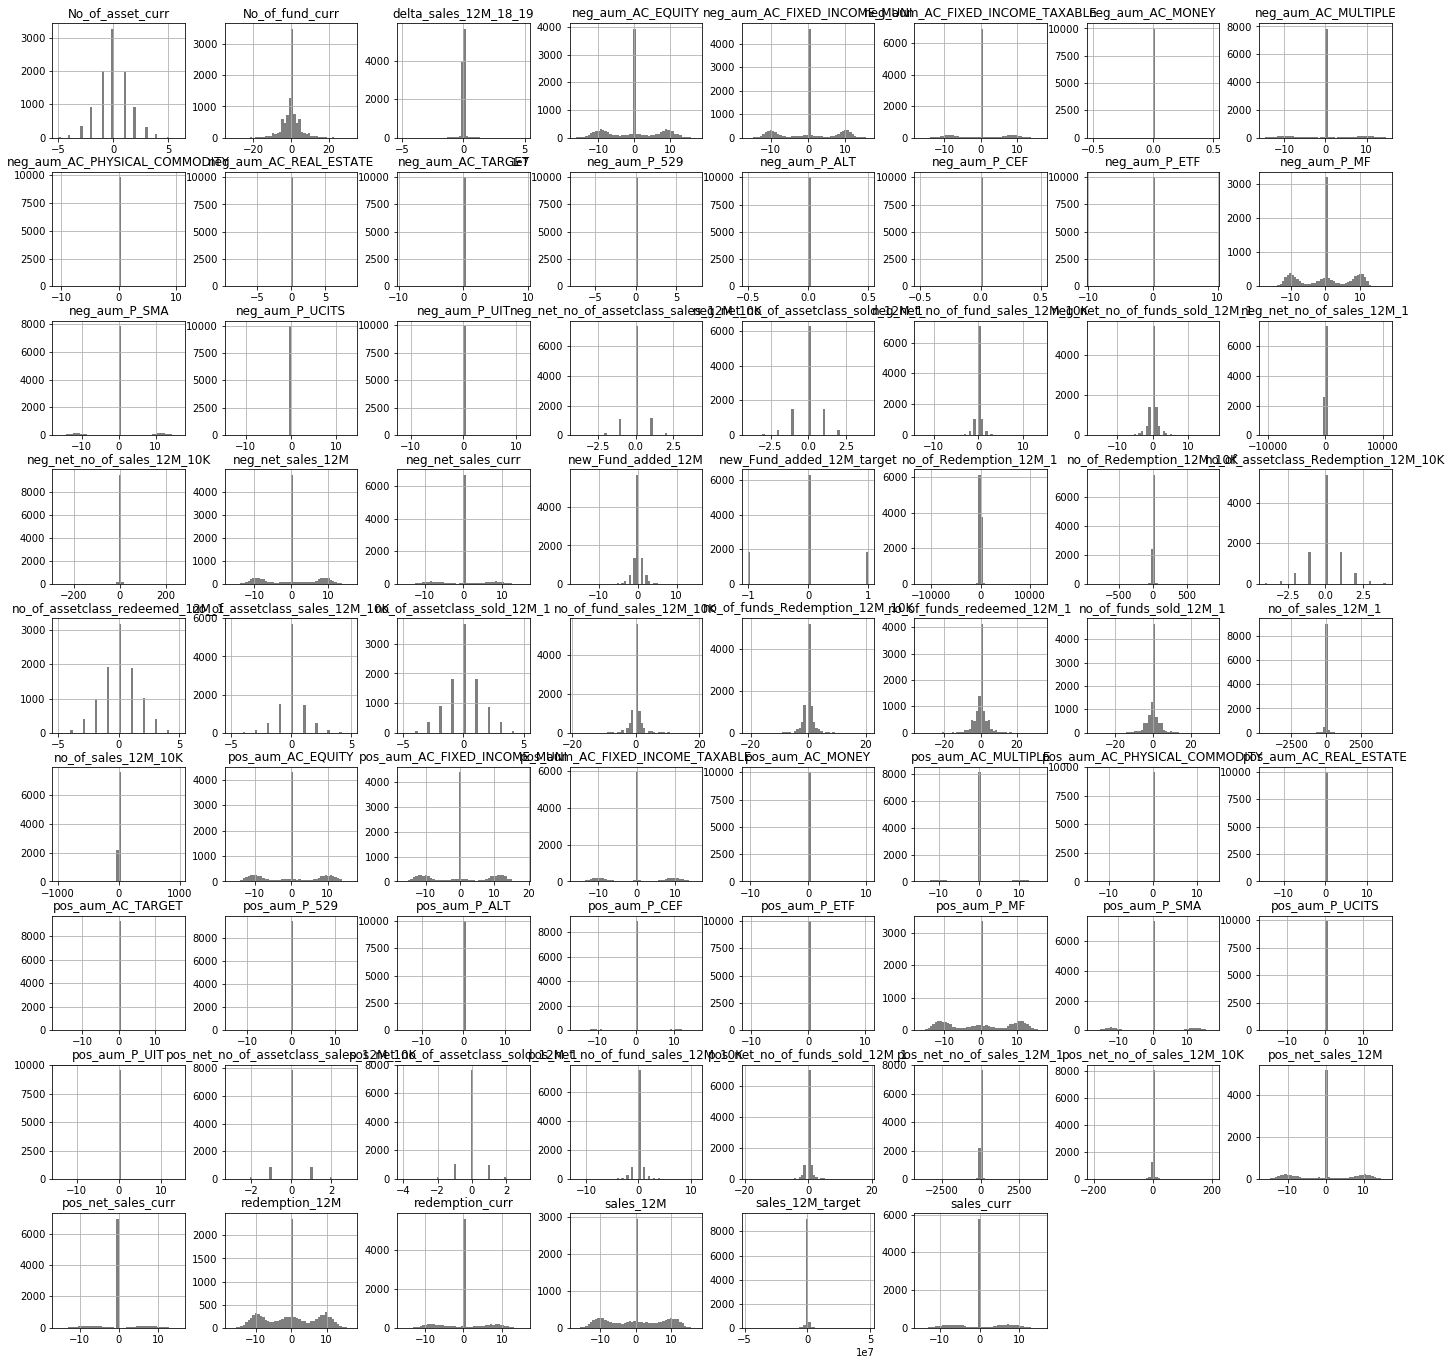

In [79]:
data.diff().hist(color='k', alpha=0.5, bins=50, figsize=(24,24))
plt.savefig('temp.jpg')

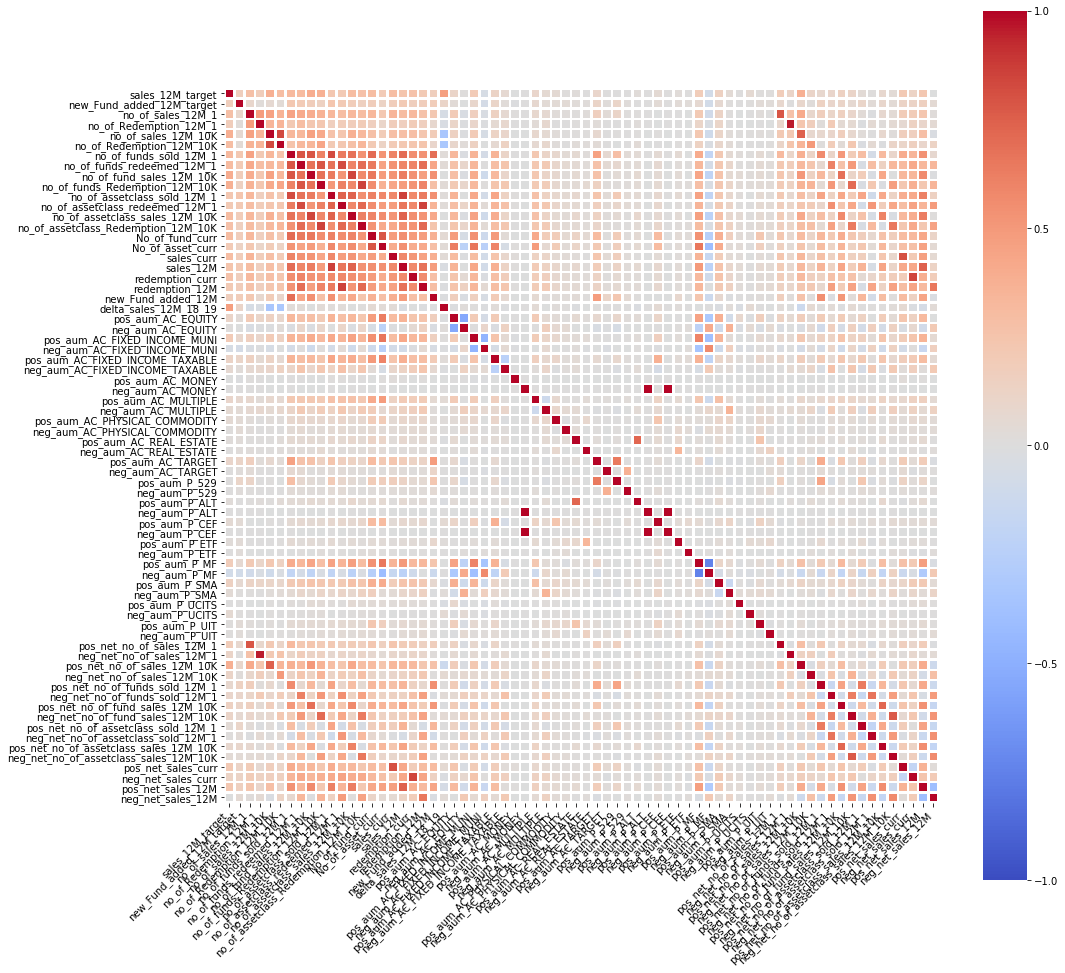

In [80]:
#plot correlation matrix
fig = plt.figure()
fig.set_size_inches(16, 16)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap='coolwarm')

#### Check dataset imbalance

In [81]:
target = 'new_Fund_added_12M_target'

In [82]:
class_probs = [len(data.loc[data[target]==0]) / len(data), len(data.loc[data[target]==1]) / len(data)]
print('Class priors:')
print('Class 0 (NO new funds added): {0:.0%}'.format(class_probs[0]))
print('Class 1 (new funds added): {0:.0%}'.format(class_probs[1]))

Class priors:
Class 0 (NO new funds added): 75%
Class 1 (new funds added): 25%
